In [105]:
import pandas as pd
import numpy as np
from google.adk.runners import InMemoryRunner
from google.adk.agents import LlmAgent
from google.adk.tools import AgentTool
from dotenv import load_dotenv
import os
import time
import traceback
import re
import codecs
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Any, Dict, Optional

In [106]:
#loading API Key
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
if os.getenv("GOOGLE_API_KEY"):
    print("API key succesfully retrieved")
else:
    print("API key not present")

API key succesfully retrieved


In [107]:
# Defines a function to load a CSV file into a pandas DataFrame.
# The 'path' argument expects a string (str) representing the file path.
# The function is type-hinted to return a pandas DataFrame (pd.DataFrame).
def loadfile(path: str) -> pd.DataFrame:
    # Uses the pandas read_csv function to load the data.
    return pd.read_csv(path)


# Defines the LoadAgent class, responsible for managing the loading process.
class LoadAgent:
    # The constructor initializes the agent with necessary components.
    # 'session' stores state information (like the DataFrame).
    # 'tool_registry' is a dictionary for accessing helper functions (like 'loadfile').
    # 'config' holds configuration options, defaulting to an empty dictionary if none is provided.
    def __init__(self, session: Dict[str, Any], tool_registry: Dict[str, Any], config: Optional[Dict[str, Any]] = None):
        self.session = session
        self.tool_registry = tool_registry
        self.config = config or {}
        # 'logs' is a list to store messages about the agent's actions.
        self.logs = []

    # Method to load a DataFrame from a specified CSV path and store it in the session.
    def getdf(self, csv_path: str) -> Dict[str, Any]:
        # Retrieves the 'loadfile' function from the tool registry and executes it
        # with the provided 'csv_path' to load the DataFrame.
        df = self.tool_registry["loadfile"](csv_path)
        # Stores the loaded DataFrame into the session dictionary under the key "df".
        self.session["df"] = df

        # Logs the successful loading action, including the shape (rows and columns) of the DataFrame.
        self.logs.append(
            f"DF loaded with {df.shape[0]} rows and {df.shape[1]} columns"
        )

        # Prints a status message to the console.
        print(f"LoaderAgent: finished – shape {df.shape}")

        # Returns a dictionary indicating the status and the dimensions of the loaded DataFrame.
        return {"status": "success", "rows": df.shape[0], "cols": df.shape[1]}

In [108]:
# Defines a class for logging, tracing, and collecting metrics for agents/processes.
class AgentLogger:
    
    # The constructor initializes the logger's storage attributes.
    def __init__(self):
        # Stores general information and error messages.
        self.logs = []
        # Stores step-by-step execution details for tracing the process flow.
        self.traces = []
        # A dictionary to track quantitative metrics related to data manipulation or performance.
        self.metrics = {
            "duplicate_rows_removed": 0,
            "missing_values_filled": 0,
            "outliers_capped": 0,
            "dtype_conversions": 0,
            # Metric to track the total execution time in seconds.
            "execution_time_sec": 0
        }

    # Logs a general message with a timestamp.
    def log(self, message: str) -> None:
        # Generates a formatted timestamp.
        ts = time.strftime("%Y-%m-%d %H:%M:%S")
        # Creates the log entry string.
        entry = f"[LOG {ts}] {message}"
        # Appends the entry to the logs list.
        self.logs.append(entry)
        # Prints the log entry to the console.
        print(entry)

    # Records a specific step in the agent's execution flow.
    def trace(self, step: str, detail: str = "") -> None:
        # Generates a formatted timestamp.
        ts = time.strftime("%Y-%m-%d %H:%M:%S")
        # Creates the trace entry string, including the step and optional detail.
        entry = f"[TRACE {ts}] {step}: {detail}"
        # Appends the entry to the traces list.
        self.traces.append(entry)
        # Prints the trace entry to the console.
        print(entry)

    # Records an error, including the exception message and traceback.
    def error(self, err: Exception) -> None:
        # Generates a formatted timestamp.
        ts = time.strftime("%Y-%m-%d %H:%M:%S")
        # Retrieves the full traceback information as a string.
        full = traceback.format_exc()
        # Creates the error entry, including the error message and the full traceback.
        entry = f"[ERROR {ts}] {err}\n{full}"
        # Appends the entry to the logs list (errors are considered part of the general log).
        self.logs.append(entry)
        # Prints the error entry to the console.
        print(entry)

    # Sets the value of a specific metric key.
    def set_metric(self, key: str, value: Any) -> None:
        # Checks if the provided key exists in the metrics dictionary before updating.
        if key in self.metrics:
            self.metrics[key] = value

    # Increments a numeric metric by a specified amount (defaults to 1).
    def increment_metric(self, key: str, amount: int = 1) -> None:
        # Checks if the provided key exists in the metrics dictionary before updating.
        if key in self.metrics:
            self.metrics[key] += amount

In [109]:
# Defines the tool registry, mapping tool names to their corresponding functions.
tool_registry = {
    "loadfile": loadfile
}

# Initializes the LoadAgent. The first argument is the empty session dictionary, 
# and the second is the tool registry.
load_instance = LoadAgent({}, tool_registry)
path=input("Enter the path of csv file: ")
# Executes the getdf method to load the specified CSV file.
# The loaded DataFrame will be stored in the load_instance's session.
result = load_instance.getdf(path)

# Prints the result dictionary returned by the getdf method (status, rows, cols).
print(result)

Enter the path of csv file:  /home/harleen/Downloads/countries of the world.csv


LoaderAgent: finished – shape (227, 20)
{'status': 'success', 'rows': 227, 'cols': 20}


In [110]:
# Get the DataFrame stored in the session
df = load_instance.session["df"]

def summary(df):
    """
    Generates a summary dictionary for the given pandas DataFrame.
    This information is useful for data analysis, profiling, and cleaning.
    """

    return {
        # List of all column names
        "columns": df.columns.tolist(),

        # Data types of each column converted to string format
        "dtypes": df.dtypes.astype(str).to_dict(),

        # Count of missing/null values in every column
        "null_counts": df.isnull().sum().to_dict(),

        # Total number of duplicate rows in the dataset
        "duplicate_rows": int(df.duplicated().sum()),

        # Statistical summary (mean, std, quartiles, etc.) 
        # for all numeric columns
        "describe_numeric": df.describe().to_dict()
    }

# Generate the summary for the DataFrame
datasummar = summary(df)
# Printing Data Summary
print(datasummar)

{'columns': ['Country', 'Region', 'Population', 'Area (sq. mi.)', 'Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)', 'Net migration', 'Infant mortality (per 1000 births)', 'GDP ($ per capita)', 'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)', 'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service'], 'dtypes': {'Country': 'object', 'Region': 'object', 'Population': 'int64', 'Area (sq. mi.)': 'int64', 'Pop. Density (per sq. mi.)': 'object', 'Coastline (coast/area ratio)': 'object', 'Net migration': 'object', 'Infant mortality (per 1000 births)': 'object', 'GDP ($ per capita)': 'float64', 'Literacy (%)': 'object', 'Phones (per 1000)': 'object', 'Arable (%)': 'object', 'Crops (%)': 'object', 'Other (%)': 'object', 'Climate': 'object', 'Birthrate': 'object', 'Deathrate': 'object', 'Agriculture': 'object', 'Industry': 'object', 'Service': 'object'}, 'null_counts': {'Country': 0, 'Region': 0, 'Population': 0, 'Area (sq. mi.)': 0, 'Pop. 

In [111]:
# Create an LLM agent responsible for generating cleaning code
cleaning_agent = LlmAgent(
    model="gemini-2.5-flash",               # The LLM model used for generating cleaning logic
    name="data_cleaning_agent",             # Unique name for this agent
    description="Analyzes data summary and suggests cleaning code",  # What this agent does
    instruction="""
You will receive a JSON object called `data_summary` with the following structure:

{
    "columns": ["col1", "col2", ...],
    "dtypes": {"col1": "int64", "col2": "object", ...},
    "null_counts": {"col1": 0, "col2": 12, ...},
    "describe_numeric": {
        "col1": {"mean": ..., "std": ..., "min": ..., "25%": ..., "50%": ..., "75%": ..., "max": ...},
        "col2": {...}
    },
    "unique_values": {"col1": [...sample...], "col2": [...sample...]},
    "duplicate_rows": 10
}

# -------------------------------------------------------------
# This agent must generate CLEANING PYTHON CODE using ONLY the 
# fields available inside the above data_summary dictionary.
# -------------------------------------------------------------

Using ONLY this structure, generate **fully runnable Python code** that performs:

1. Remove duplicates if duplicate_count > 0  
2. Handle missing values based on dtype  
3. Detect numeric outliers and, if they are not significant, cap them using the IQR method  
   - Use Q1 = describe_numeric[col]["25%"]  
   - Use Q3 = describe_numeric[col]["75%"]  
   - Cap values to lower/upper bounds  
4. Convert dtypes properly (int, float, datetime, object)
5. DO NOT invent any fields not present in data_summary  
6. Output a single Python function named `cleandata` that accepts two arguments dataframe and summary 
   - Output ONLY raw Python code (no JSON/markdown wrappers)  
7. Add comment "Pythoncodestarting" at start and "pythoncodeending" at end  
8. Ensure code uses updated, non-deprecated Pandas operations  
   - Example: Instead of df[col].fillna(val, inplace=True)  
     use df[col] = df[col].fillna(val)  
9. All code must be executable as-is and must avoid dtype warnings  
   such as "dtype incompatible with int64"  
   → This means explicit casting should be handled properly.

# The agent now uses these instructions to generate the cleaning code.
"""
)


In [112]:
def extractcode(response):
    """
    Extract python code between Pythoncodestarting and pythoncodeending markers.
    Works even if response is a list (e.g., LLM streaming events).
    """
    # If response is list, convert to a single string
    if isinstance(response, list):
        response = "".join(str(item) for item in response)

    # Ensure response is a string
    if not isinstance(response, str):
        raise TypeError("Response must be a string or list of strings")

    pattern = r"Pythoncodestarting(.*?)pythoncodeending"
    match = re.search(pattern, response, flags=re.DOTALL)

    if match:
        return match.group(1).strip()
    else:
        return None


In [113]:
import codecs
import textwrap
import time

def execute_code_from_response(response, extract_fn, target_fn_name="cleandata"):
    """
    Extracts Python code from an LLM response, cleans it,
    dynamically executes it, and returns the target function.

    Args:
        response (str): Raw LLM response.
        extract_fn (callable): Function that extracts only the code block.
        target_fn_name (str): Name of the function expected inside the extracted code.

    Returns:
        callable: Executed function object with name target_fn_name.
    """

    # Extract the code string from the model response
    code_string = extract_fn(response) if callable(extract_fn) else extract_fn(response)

    # Convert escaped characters like \n, \t to real newlines/tabs
    code_string = codecs.decode(code_string, 'unicode_escape')

    # Remove accidental indentation that often appears in code blocks
    code_string = textwrap.dedent(code_string)

    # Execute the code in an isolated local namespace
    local_vars = {}
    exec(code_string, globals(), local_vars)

    # Retrieve the expected function from executed code
    if target_fn_name not in local_vars:
        raise ValueError(f"Function '{target_fn_name}' not found in executed code.")

    return local_vars[target_fn_name]



# -------------------------------
# CleanAgent using the extractor
# -------------------------------

class CleanAgent:
    def __init__(self, session, tool_registry, config=None):
        self.session = session
        self.tool_registry = tool_registry
        self.config = config or {}
        self.logger = AgentLogger()
        self.logs = []  # Keeping your original local logs list

    def executecode(self, response):
        start_time = time.time()
        self.logger.trace("executecode_start")

        # Retrieve extraction function from the tool registry
        extract_fn = self.tool_registry.get("extractcode")
        if extract_fn is None:
            raise ValueError("tool_registry must contain an 'extractcode' callable")

        self.logger.log("Extracting code from LLM response")

        # Dynamically extract and load cleandata() function
        cleandata_fn = execute_code_from_response(
            response, extract_fn, target_fn_name="cleandata"
        )

        # Retrieve session inputs
        df = self.session.get("df")
        datasummar = self.session.get("datasummar")

        if df is None or datasummar is None:
            raise ValueError("Session must contain both 'df' and 'datasummar'")

        self.logger.log(f"Running cleandata() on df shape {df.shape}")

        # Your original logic: call cleandata twice
        cleaned_df = cleandata_fn(df, datasummar)
        cleaned_df = cleandata_fn(df, datasummar)

        # Update the session with cleaned dataframe
        self.session["df"] = cleaned_df

        # Maintain your original logging
        self.logs.append(f"Data cleaned – shape now {cleaned_df.shape}")
        print(f"CleanAgent: finished – shape {cleaned_df.shape}")

        # Record execution time metric
        exec_time = round(time.time() - start_time, 4)
        self.logger.set_metric("execution_time_sec", exec_time)
        self.logger.log(f"Execution Time: {exec_time}s")
        self.logger.trace("executecode_end")

        return {
            "status": "success",
            "rows": cleaned_df.shape[0],
            "cols": cleaned_df.shape[1],
            "metrics": self.logger.metrics,
            "logs": self.logger.logs,
            "traces": self.logger.traces
        }


In [114]:
# Store the generated data summary in the session
load_instance.session["datasummar"] = datasummar

# Register the code extraction tool for the cleaning agent
tool_registry_clean = {"extractcode": extractcode}

# Create an instance of the CleanAgent with the active session and tools
clean_agent_instance = CleanAgent(load_instance.session, tool_registry_clean)

# Run the LLM-powered cleaning agent to generate cleaning code
cleaningdata = InMemoryRunner(agent=cleaning_agent, app_name="agents")
cleandataresponse = await cleaningdata.run_debug({"data_summary": datasummar})
print(cleandataresponse)

# Execute the generated cleaning code on the dataframe
result = clean_agent_instance.executecode(cleandataresponse)

# Display the final result containing metrics, logs, and cleaned data info
print(result)


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.



 ### Created new session: debug_session_id

User > data_summary
data_cleaning_agent > Pythoncodestarting
import pandas as pd
import numpy as np

def cleandata(dataframe, summary):
    df = dataframe.copy() # Work on a copy to avoid modifying the original DataFrame

    # 1. Remove duplicates if duplicate_rows > 0
    if summary.get("duplicate_rows", 0) > 0:
        df = df.drop_duplicates()

    # 2. Handle missing values based on dtype
    for col in summary["columns"]:
        if summary["null_counts"].get(col, 0) > 0:
            dtype = summary["dtypes"].get(col)

            if dtype in ["int64", "float64"]:
                # Impute numeric columns with their mean from the summary
                if col in summary["describe_numeric"]:
                    fill_value = summary["describe_numeric"][col]["mean"]
                    df[col] = df[col].fillna(fill_value)
            elif dtype == "object":
                # For object (categorical/string) columns, fill with 'Unknown'
   

In [115]:
#Pritning DataFrame
print(df)

             Country                               Region  Population  \
0       Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1           Albania   EASTERN EUROPE                          3581655   
2           Algeria   NORTHERN AFRICA                        32930091   
3    American Samoa   OCEANIA                                   57794   
4           Andorra   WESTERN EUROPE                            71201   
..               ...                                  ...         ...   
222       West Bank   NEAR EAST                               2460492   
223  Western Sahara   NORTHERN AFRICA                          273008   
224           Yemen   NEAR EAST                              21456188   
225          Zambia   SUB-SAHARAN AFRICA                     11502010   
226        Zimbabwe   SUB-SAHARAN AFRICA                     12236805   

     Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0            647500                       48

In [116]:
#Updating summary
datasummary=summary(df)

#Printing Summary
print(datasummary)

{'columns': ['Country', 'Region', 'Population', 'Area (sq. mi.)', 'Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)', 'Net migration', 'Infant mortality (per 1000 births)', 'GDP ($ per capita)', 'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)', 'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service'], 'dtypes': {'Country': 'object', 'Region': 'object', 'Population': 'int64', 'Area (sq. mi.)': 'int64', 'Pop. Density (per sq. mi.)': 'object', 'Coastline (coast/area ratio)': 'object', 'Net migration': 'object', 'Infant mortality (per 1000 births)': 'object', 'GDP ($ per capita)': 'float64', 'Literacy (%)': 'object', 'Phones (per 1000)': 'object', 'Arable (%)': 'object', 'Crops (%)': 'object', 'Other (%)': 'object', 'Climate': 'object', 'Birthrate': 'object', 'Deathrate': 'object', 'Agriculture': 'object', 'Industry': 'object', 'Service': 'object'}, 'null_counts': {'Country': 0, 'Region': 0, 'Population': 0, 'Area (sq. mi.)': 0, 'Pop. 

In [117]:
# Creating an instance of LlmAgent for suggesting visualizations based on dataset columns
inferenceagent = LlmAgent(
    model="gemini-2.5-flash",   # Using Gemini 2.5 Flash model for fast reasoning
    name="visualsuggestionagent",   # Agent name used to identify its purpose
    description="Analyzes list of columns and suggest what visualizations can be created",
    
    # Instruction block that tells the LLM exactly how to behave
    instruction="""
You will receive top 5 rows of a dataset.

Your task is to analyze the columns and suggest what kind of visualizations would commonly be created from dataset

Decide 5 key **Visualization or Inferences** that must be interpreted for meaningful visualization and conclusions in a way that at maximum only 5 charts are created. 
State what the visualization should show and what decision it will help make.

1.  **Inference/Visualization 1:** 
2.  **Inference/Visualization 2:** 
3.  **Inference/Visualization 3:**
4.  **Inference/Visualization 4:**
5.  **Inference/Visualization 5:**

6. **DO NOT invent any fields not present in data_summary.**   # Ensures model only uses available columns and avoids hallucinating fields
"""
)


In [118]:
import json

async def vissuggestions(datasummary):
    # Initialize the inference agent runner using the previously created 'inferenceagent'
    inference_runner = InMemoryRunner(agent=inferenceagent, app_name="agents")
    
    # Prepare the payload expected by the agent:
    # - 'columns' : list of dataset column names
    # - 'sample_rows' : optional top sample rows from dataset
    payload = {
        "data_summary": {
            "columns": datasummary['columns'],
            "sample_rows": datasummary.get("sample_rows", [])  # Include sample rows only if available
        }
    }

    # Convert the payload dictionary to a JSON string
    json_string = json.dumps(payload)
    
    # Run the agent in debug mode to get detailed reasoning and output
    result = await inference_runner.run_debug(json_string)
    return result

# Example usage of the async function to get visualization suggestions
visualsuggestions = await vissuggestions(datasummary)


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.



 ### Created new session: debug_session_id

User > {"data_summary": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "sample_rows": []}}
visualsuggestionagent > 1.  **Inference/Visualization 1:** **Regional Economic Performance Comparison**
    *   **What it should show:** A Bar chart displaying the average `GDP ($ per capita)` for each `Region`.
    *   **What decision it will help make:** Identify regions with the highest and lowest economic output, helping inform investment strategies, international aid allocation, or policy development targeted at regional economic disparities.

2.  **Inference/Visualization 2:** **Relationship Between Economic Prosperity and Health Outcomes**


In [119]:
# Creating an LLM agent responsible for deciding feature engineering steps
featuredecideagent = LlmAgent(
    model="gemini-2.5-flash",   # Using Gemini model optimized for fast reasoning
    name="data_featuredeciding_agent",  # Unique name for identifying this agent
    
    # Description of what this agent is supposed to do
    description=(
        "Analyzes data summary, top 5 rows of dataset, and the visualizations we intend to derive, "
        "and determines whether any feature needs modification or new feature creation."
    ),
    
    # Instruction block given to agent describing expected reasoning and output format
    instruction="""
You will receive a JSON object called `data_summary` with the following structure:

{
    "columns": ["col1", "col2", ...],
    "dtypes": {"col1": "int64", "col2": "object", ...},
    "null_counts": {"col1": 0, "col2": 12, ...},
    "describe_numeric": {
        "col1": {"mean": ..., "std": ..., "min": ..., "25%": ..., "50%": ..., "75%": ..., "max": ...},
        "col2": {...}
    },
    "unique_values": {"col1": [...sample...], "col2": [...sample...]},
    "duplicate_count": 10
}

You will also receive:
- The top 5 rows of the dataset
- A string describing which visualizations we plan to generate

Your task:
Using ONLY this information, determine if any feature engineering is required.

1. Identify if any feature requires normalization or similar transformation
2. Determine if a new feature should be created
3. Identify any valid and necessary feature engineering steps
4. Suggest dtype conversions (int, float, datetime, object)
5. DO NOT invent any fields not present in data_summary
6. Output ONLY the specific changes needed for different columns
7. Before listing the first change, output the text: herechangesstart  
   After completing all changes, end with the text: heretextends
"""
)


In [120]:
async def featurechanges():
    # Initialize the runner for the feature-deciding agent
    feat_runner = InMemoryRunner(agent=featuredecideagent, app_name="agents")
    
    # Create the payload to send to the agent:
    # - data_head: only includes columns + first 5 sample rows
    # - data_summary: complete summary dictionary (wrapped under "summary")
    # - visualizations: string form of visualization suggestions generated earlier
    payload = {
        "data_head": {
            "columns": datasummary['columns'],
            "sample_rows": datasummary.get("sample_rows", [])  # optional sample rows
        },
        "data_summary": {"summary": datasummary},  # full dataset summary
        "visualizations": {"visualizations": str(visualsuggestions)}  # inferred visualization text
    }

    # Convert the payload dictionary into a JSON string
    json_string = json.dumps(payload)
    
    # Execute the agent in debug mode (returns reasoning + output)
    result = await feat_runner.run_debug(json_string)
    
    # Return the final processed output from the agent
    return result


In [121]:
#Running Feature changes function
featuretochange=await featurechanges()


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.



 ### Created new session: debug_session_id

User > {"data_head": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "sample_rows": []}, "data_summary": {"summary": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "dtypes": {"Country": "object", "Region": "object", "Population": "int64", "Area (sq. mi.)": "int64", "Pop. Density (per sq. mi.)": "object", "Coastline (coast/area ratio

In [122]:
#Function to extract string of changes to implement 
def extractstring(texttochange):

# Suppose this is the raw string
    raw_text = str(texttochange)  

# Extract text between 'herechangesstart' and 'heretextends'
    match = re.search(r"herechangesstart(.*?)heretextends", raw_text, re.DOTALL)
    if match:
        changes_text = match.group(1).strip()
    else:
        print("No match found")
    return changes_text


In [123]:
#Running extract string function
featurechangestoimplement=extractstring(featuretochange)

In [124]:
# LLM agent responsible for generating Python feature-engineering code
feature_engineering_agent = LlmAgent(
    model="gemini-2.5-flash",   # Model used to generate transformation code
    name="data_cleaning_agent",  # Name identifying this agent's purpose
    
    # Description of the agent's functionality
    description="Analyzes data summary, head of dataframe and provide code for feature engineering",
    
    # Detailed instructions that tell the LLM exactly how to behave
    instruction="""
You will receive a JSON object called `data_summary` with the following structure:

{
    "columns": ["col1", "col2", ...],
    "dtypes": {"col1": "int64", "col2": "object", ...},
    "null_counts": {"col1": 0, "col2": 12, ...},
    "describe_numeric": {
        "col1": {"mean": ..., "std": ..., "min": ..., "25%": ..., "50%": ..., "75%": ..., "max": ...},
        "col2": {...}
    },
    "unique_values": {"col1": [...sample...], "col2": [...sample...]},
    "duplicate_count": 10
}

You will also receive:
- A payload with the top 10 rows of the dataset
- A list of feature changes that must be implemented

Using ONLY this information, generate **fully runnable Python code** that performs the required feature engineering.

Requirements:

1. Apply all changes specified in the feature list  
2. Handle datatype conversions properly  
3. DO NOT invent any fields not present in data_summary  
4. Output a single Python function called `featureengineering` containing all transformations  
   - Output **raw Python code only**, NOT JSON or Markdown formatting  
5. Start the code with the comment: Pythoncodestarting  
   End the code with the comment: pythoncodeending  
6. Ensure all methods used are up-to-date and not deprecated  
7. Avoid generating warnings related to deprecated `inplace` usage  
"""
)


In [125]:
async def feature_engineering():
    # Initialize the runner for the feature engineering agent
    feature_runner = InMemoryRunner(agent=feature_engineering_agent, app_name="agents")
    
    # Prepare payload containing:
    # - data_head: dataset columns + sample top rows
    # - data_summary: full summary dictionary
    # - featurechangestoimplement: feature changes generated by previous agent
    payload = {
        "data_head": {
            "columns": datasummary['columns'],
            "sample_rows": datasummary.get("sample_rows", [])  # Optional top rows
        },
        "data_summary": {"summary": datasummary},  # Full dataset summary
        "featurechangestoimplement": {
            "featurechanges": featurechangestoimplement  # Changes to apply
        }
    }

    # Convert payload to a JSON string
    json_string = json.dumps(payload)
    
    # Execute the LLM agent using its runner (debug mode returns reasoning + output)
    result = await feature_runner.run_debug(json_string)
    
    # Return the final result produced by the agent
    return result


In [126]:
class FeatureEngineeringAgent:
    def __init__(self, session, tool_registry, config=None):
        # Session stores shared objects like df, datasummary, etc.
        self.session = session
        
        # Registry containing helper tools (extractcode, etc.)
        self.tool_registry = tool_registry
        
        # Optional config
        self.config = config or {}
        
        # Logger for traces, logs, metrics
        self.logger = AgentLogger()
        
        # Human-readable logs
        self.logs = []

    def executecode(self, response):
        # Start trace for feature engineering execution
        self.logger.trace("feature_engineering_start")

        # Begin extracting Python code from LLM response
        self.logger.trace("extractcode_start")
        extract_fn = self.tool_registry.get("extractcode")
        if extract_fn is None:
            raise ValueError("tool_registry must contain 'extractcode' key with callable value")

        # Log that extraction is happening
        self.logger.log("Extracting featureengineering() function from LLM response")

        # Time extraction for metrics
        t0 = time.time()

        # Convert LLM response into executable Python function named "featureengineering"
        featureengineering_fn = execute_code_from_response(
            response, extract_fn, target_fn_name="featureengineering"
        )
        # print(featureengineering_fn)
        # help(featureengineering_fn)

        # Record extraction time
        extract_time = time.time() - t0
        self.logger.set_metric("featureengineering_extraction_time_sec", extract_time)

        # Extraction trace end
        self.logger.trace("extractcode_end")

        # Retrieve dataset and summary from session
        df = self.session.get("df")
        datasummary = self.session.get("datasummary")

        # Validate required session values
        if df is None or datasummary is None:
            raise ValueError("Session must contain 'df' and 'datasummary'")

        # Pre-execution metrics
        before_rows, before_cols = df.shape
        mem_before = df.memory_usage(deep=True).sum()
        self.logger.set_metric("df_rows_before", before_rows)
        self.logger.set_metric("df_cols_before", before_cols)
        self.logger.set_metric("df_memory_before_bytes", mem_before)

        # ==== EXECUTE FEATURE ENGINEERING FUNCTION ====
        self.logger.trace("featureengineering_fn_start")
        self.logger.log(f"Running featureengineering() on df shape {df.shape}")

        t1 = time.time()

        # Call the generated function with only df as input
        engineered_df = featureengineering_fn(df)

        # Measure execution time
        exec_time = time.time() - t1
        self.logger.set_metric("featureengineering_execution_time_sec", exec_time)
        self.logger.trace("featureengineering_fn_end")

        # ==== POST-EXECUTION METRICS ====
        after_rows, after_cols = engineered_df.shape
        mem_after = engineered_df.memory_usage(deep=True).sum()

        # Save updated dataset metrics
        self.logger.set_metric("df_rows_after", after_rows)
        self.logger.set_metric("df_cols_after", after_cols)
        self.logger.set_metric("df_memory_after_bytes", mem_after)

        # Track column changes: added or removed
        col_change = after_cols - before_cols
        self.logger.set_metric("new_columns_added", max(0, col_change))
        self.logger.set_metric("columns_removed", max(0, -col_change))

        # ==== UPDATE SESSION WITH NEW DATAFRAME ====
        self.session["df"] = engineered_df

        # Human-readable summary log
        self.logs.append(
            f"Features engineered – shape changed {before_rows}x{before_cols} → {after_rows}x{after_cols}"
        )
        print(f"FeatureEngineeringAgent: finished – shape {engineered_df.shape}")

        # Mark end of agent run
        self.logger.trace("feature_engineering_end")

        # Final return with updated shape info
        return {
            "status": "success",
            "rows": engineered_df.shape[0],
            "cols": engineered_df.shape[1]
        }


In [127]:
# 1️⃣ Prepare your session and tool registry
session = {
    "df": df,  # your current DataFrame
    "datasummary": datasummary  # summary dictionary you already have
}

tool_registry = {
    "extractcode": extractcode  # your code extraction function
}

# 2️⃣ Call the LLM to get the feature engineering code
llm_response = await feature_engineering()  # async function returns the LLM code string

# 3️⃣ Instantiate the agent
agent = FeatureEngineeringAgent(session=session, tool_registry=tool_registry)

# 4️⃣ Execute the feature engineering code on your DataFrame
result = agent.executecode(llm_response)

# 5️⃣ Check the updated DataFrame
df = session["df"]
print(df.head())
print(result)  # shows status, rows, cols


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.



 ### Created new session: debug_session_id

User > {"data_head": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "sample_rows": []}, "data_summary": {"summary": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "dtypes": {"Country": "object", "Region": "object", "Population": "int64", "Area (sq. mi.)": "int64", "Pop. Density (per sq. mi.)": "object", "Coastline (coast/area ratio

In [128]:
#Reloading Summary
datasummary=summary(df)

In [129]:
# LLM agent responsible for generating Python visualization code
visualization_agent = LlmAgent(
    model="gemini-2.5-flash",   # Fast reasoning model used to generate plotting code
    name="data_visualization_agent",  # Identifier for the visualization agent
    
    # Description of what this agent is meant to do
    description="Analyzes visualization suggestions, head of data frame, features and provide code for visualization",
    
    # Instructions defining exactly how the LLM should behave and what output format it must follow
    instruction="""
You will receive a JSON object called `data_summary` with the following structure:

{
    "columns": ["col1", "col2", ...],
    "dtypes": {"col1": "int64", "col2": "object", ...},
    "null_counts": {"col1": 0, "col2": 12, ...},
    "describe_numeric": {
        "col1": {"mean": ..., "std": ..., "min": ..., "25%": ..., "50%": ..., "75%": ..., "max": ...},
        "col2": {...}
    },
    "unique_values": {"col1": [...sample...], "col2": [...sample...]},
    "duplicate_count": 10
}

You will also receive:
- Top 10 rows of the dataframe  
- The visualization suggestions generated earlier

Using ONLY this information, generate **fully runnable Python code** that performs:

1. Create visualizations using Matplotlib and Seaborn  
2. Ensure datatype handling is correct  
3. DO NOT invent fields or columns that do not exist  
4. Output one complete Python function named `visualization`:
     - Function must be `def visualization(df):`
     - Output must be **raw Python code ONLY** (no JSON, no markdown wrappers)
5. Begin the generated code with the comment: Pythoncodestarting  
   End the code with the comment: pythoncodeending  
6. Ensure all methods used are modern, non-deprecated, and produce no warnings  
7 Dont use anyhting that raises warnings like this FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<string>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.
"""
)


In [130]:
async def visualizationcode():
    # Initialize the runner for the visualization agent
    feature_runner = InMemoryRunner(agent=visualization_agent, app_name="agents")
    
    # Prepare the payload to send to the agent:
    # - data_head: contains dataset column names + sample top rows
    # - data_summary: full dataset summary dictionary
    # - visualization_suggestions: string version of the earlier LLM-generated suggestions
    payload = {
        "data_head": {
            "columns": datasummary['columns'],
            "sample_rows": datasummary.get("sample_rows", [])  # optional top sample rows
        },
        "data_summary": {"summary": datasummary},  # full summary of dataset
        "visualization_suggestions": {
            "visualizationsuggestions": str(visualsuggestions)  # suggestions text
        }
    }

    # Convert the payload to a JSON string for the runner
    json_string = json.dumps(payload)
    
    # Execute the agent using run_debug (returns reasoning + final output)
    result = await feature_runner.run_debug(json_string)
    
    # Return the generated visualization code from the agent
    return result


In [131]:
class VisualizationAgent:
    """
    Executes the visualization code generated by an LLM agent.
    
    It does NOT persist any changes to the DataFrame back to the session,
    because the visualization agent is only responsible for plotting,
    not modifying or engineering the data.
    """

    def __init__(self, session: Dict[str, Any], tool_registry: Dict[str, Callable], config: Optional[Dict] = None):
        # Store session dictionary where df and datasummary are kept
        self.session = session
        
        # Tool registry contains helper functions (like extractcode)
        self.tool_registry = tool_registry
        
        # Optional configuration
        self.config = config or {}
        
        # Human-readable logs
        self.logs = []

        # Initialize logger for traces / metrics
        self.logger = AgentLogger()
        self.logger.trace("VisualizationAgent_initialized")  # Trace creation of agent

    def executecode(self, response: str) -> Dict[str, Any]:

        # Mark start of execution
        self.logger.trace("executecode_start")
        t0 = time.time()

        # Get the extractcode tool for converting LLM output into Python
        extract_fn = self.tool_registry.get("extractcode")
        if extract_fn is None:
            raise ValueError("tool_registry must contain 'extractcode' key with callable value")

        # Log extraction process
        self.logger.log("Extracting visualization() function from LLM response")

        # Extract and compile the visualization() function from LLM response
        visualization_fn = execute_code_from_response(
            response,
            extract_fn,
            target_fn_name="visualization"
        )

        # Log time taken for extraction
        extract_time = time.time() - t0
        self.logger.set_metric("visualization_extraction_time_sec", extract_time)

        # Confirm which function was loaded
        self.logger.log(f"Loaded function: {visualization_fn.__name__}")

        # Retrieve dataframe and summary from session
        df: pd.DataFrame = self.session.get("df")
        datasummary: Dict = self.session.get("datasummary")

        # Validate required session fields
        if df is None or not isinstance(df, pd.DataFrame):
            raise ValueError("Session must contain a pandas DataFrame under key 'df'")
        if datasummary is None:
            raise ValueError("Session must contain 'datasummary'")

        # Log dataframe shape before visualization
        before_rows, before_cols = df.shape
        self.logger.set_metric("df_rows_before_visualization", before_rows)
        self.logger.set_metric("df_cols_before_visualization", before_cols)
        self.logger.log(f"Visualization running on df shape {df.shape}")

        # Execute the generated visualization function
        self.logger.trace("visualization_fn_start")
        t1 = time.time()

        # visualization() must accept df; return value is ignored intentionally
        visualized_df = visualization_fn(df)

        # Record execution time
        exec_time = time.time() - t1
        self.logger.set_metric("visualization_execution_time_sec", exec_time)
        self.logger.trace("visualization_fn_end")

        # Note: No df modifications are written back — by design
        self.logger.log("Visualization executed (no dataframe modification applied)")

        # Track how many times visualizations have run
        self.logger.increment_metric("visualization_runs", 1)

        # Add a human-readable log entry
        self.logs.append("Visualization done")
        print("Visualization: finished")

        # Mark end of execution trace
        self.logger.trace("executecode_end")

        # Return simple status response
        return {"status": "success"}


In [132]:
# Calling the async function and get the Python code string
llm_response = await visualizationcode()


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.



 ### Created new session: debug_session_id

User > {"data_head": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "sample_rows": []}, "data_summary": {"summary": {"columns": ["Country", "Region", "Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)", "Coastline (coast/area ratio)", "Net migration", "Infant mortality (per 1000 births)", "GDP ($ per capita)", "Literacy (%)", "Phones (per 1000)", "Arable (%)", "Crops (%)", "Other (%)", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"], "dtypes": {"Country": "object", "Region": "object", "Population": "int64", "Area (sq. mi.)": "int64", "Pop. Density (per sq. mi.)": "float64", "Coastline (coast/area rati

[TRACE 2025-11-22 23:49:55] VisualizationAgent_initialized: 
[TRACE 2025-11-22 23:49:55] executecode_start: 
[LOG 2025-11-22 23:49:55] Extracting visualization() function from LLM response
[LOG 2025-11-22 23:49:55] Loaded function: visualization
[LOG 2025-11-22 23:49:55] Visualization running on df shape (227, 20)
[TRACE 2025-11-22 23:49:55] visualization_fn_start: 


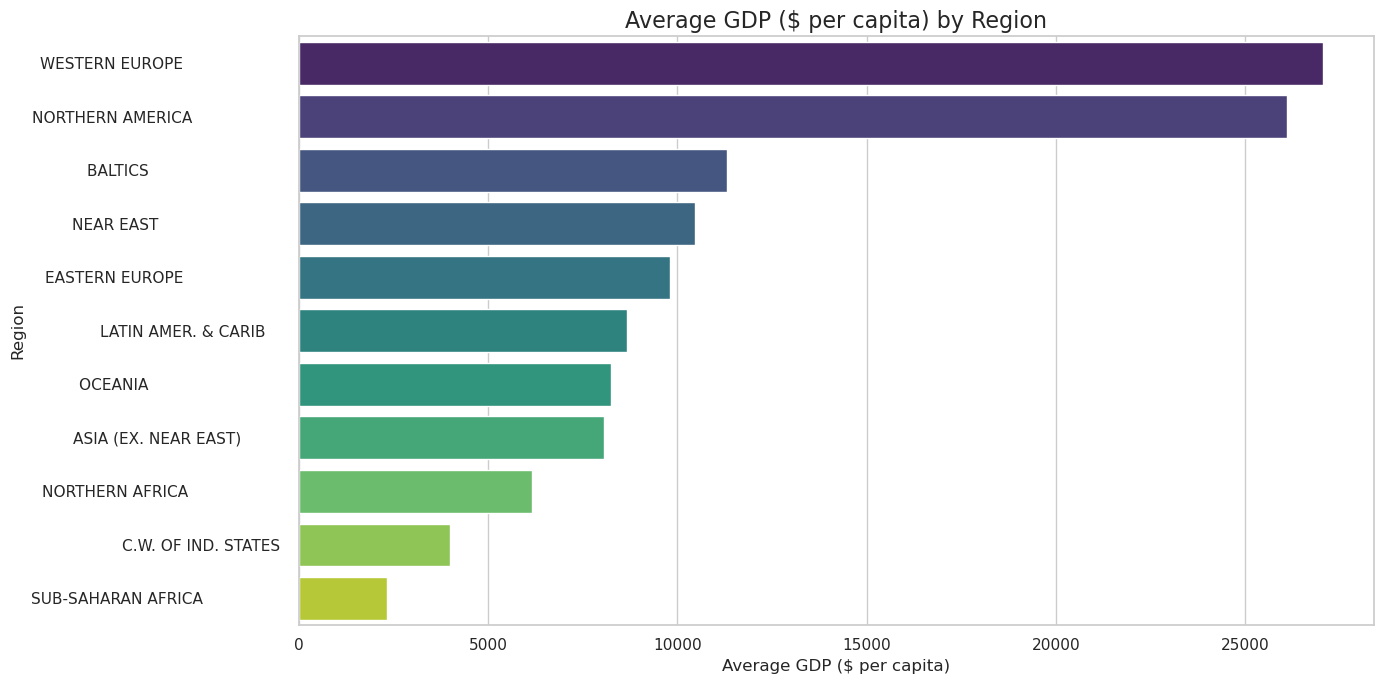

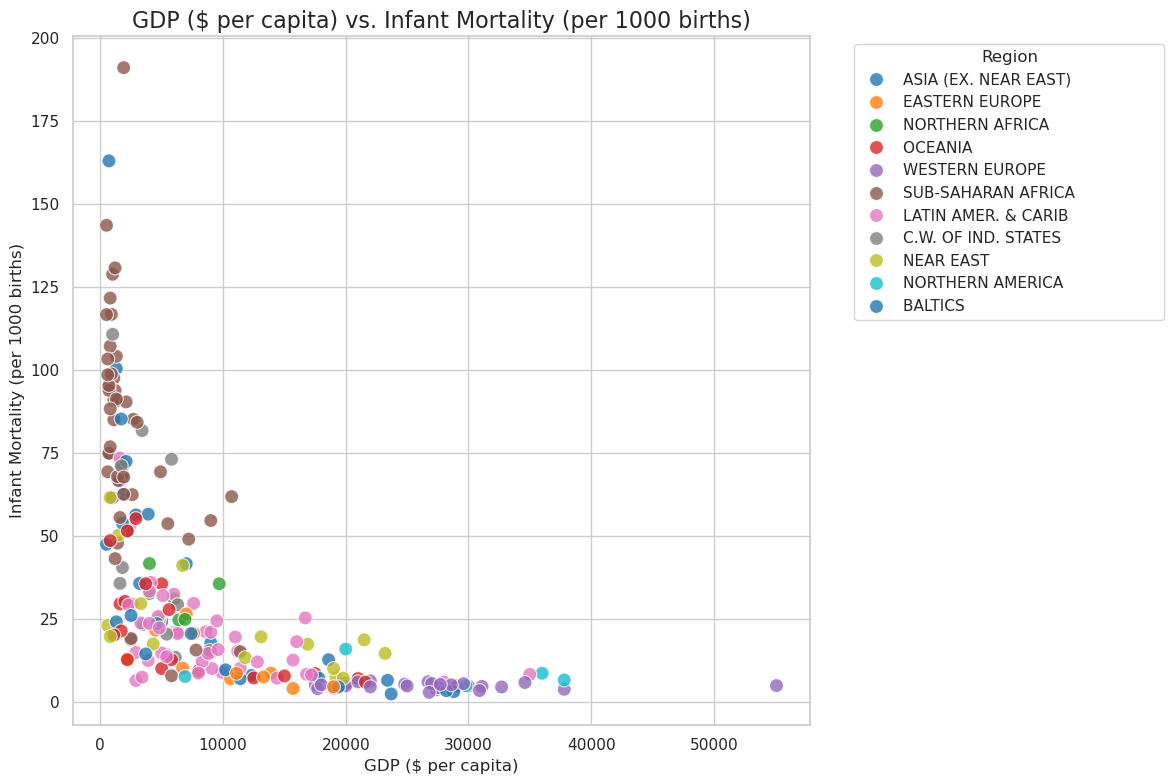

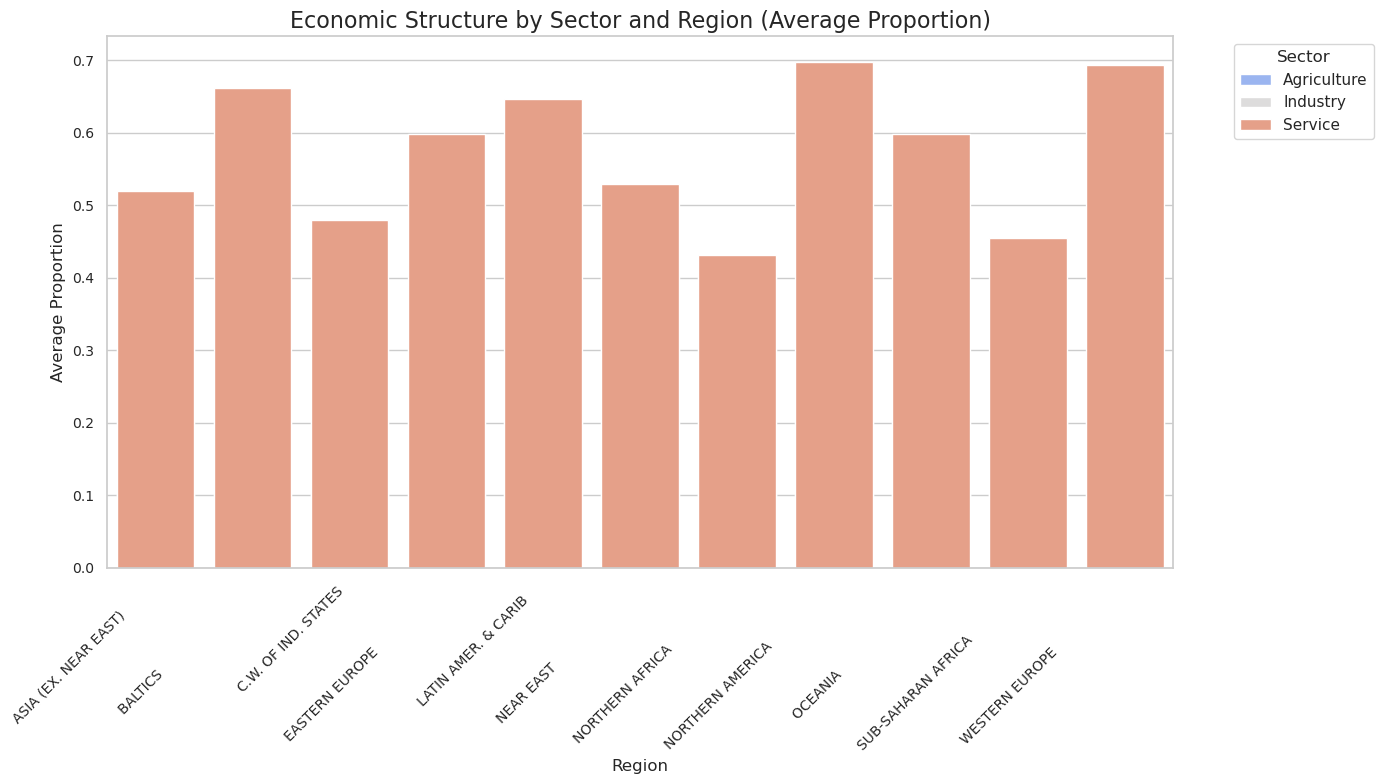

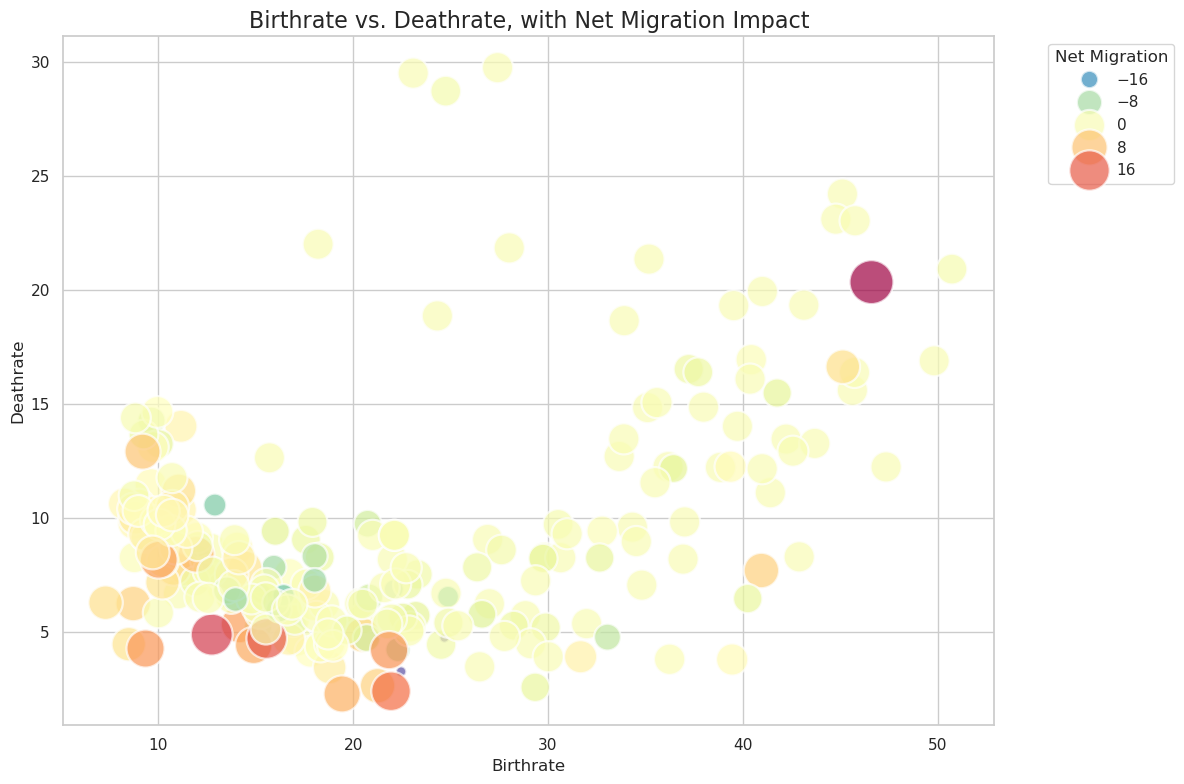

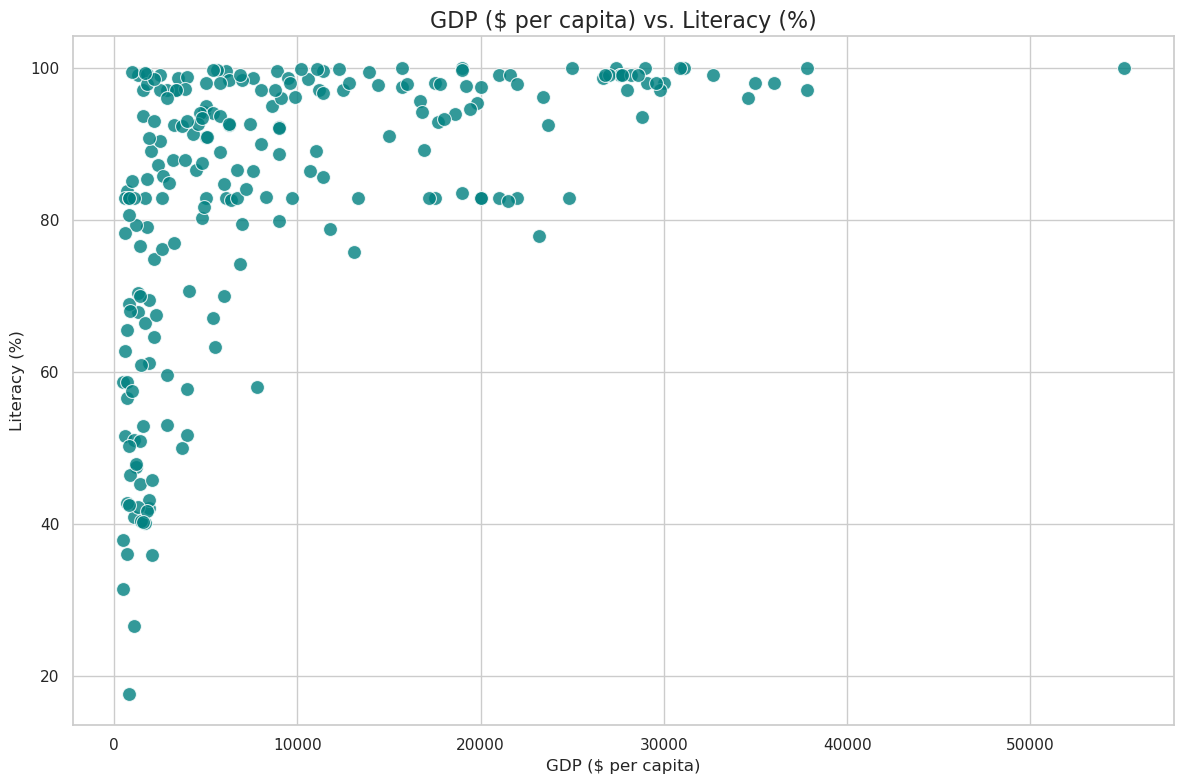

[TRACE 2025-11-22 23:49:57] visualization_fn_end: 
[LOG 2025-11-22 23:49:57] Visualization executed (no dataframe modification applied)
Visualization: finished
[TRACE 2025-11-22 23:49:57] executecode_end: 
{'status': 'success'}


In [133]:
visual_agent = VisualizationAgent(session=session, tool_registry=tool_registry)

# --- Executing the visualization ---
result = visual_agent.executecode(llm_response)
print(result)